### Зависимости

In [1]:
import pymorphy2
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
import itertools
import string
from stop_words import get_stop_words
from corus import load_wiki
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### Загружаем список стоп-слов и пунктуационных знаков

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/adpashnin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adpashnin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Считываем дамп Вики, загруженный из https://github.com/natasha/corus

In [20]:
print("Чтение текстов из Вики")
path = 'ruwiki-latest-pages-articles.xml.bz2'
records = load_wiki(path)

### Подготавливаем тексты из Вики для TF-IDF

In [4]:
print("Подготовка текстов из Вики")
wiki_texts = []
for i in range(100):
    wiki_texts.append(next(records).text)

Подготовка текстов из Вики
Подготовка текстов из Вики завершена


### Токенизируем текст, вычищая стоп-слова и производя лемматизацию

In [5]:
def tokenize_ru(file_text):
    # firstly let's apply nltk tokenization
    tokens = word_tokenize(file_text)

    # let's delete punctuation symbols
    tokens = [i for i in tokens if (i not in string.punctuation)]

    # deleting stop_words
    stop_words = stopwords.words('russian') + get_stop_words('ru')
    stop_words.extend(['в', '', '•', '—', '–', 'к', 'на', '№', '©', '►','3–4','1–2','2–3', '5–7', '15–20', '10-15', '20–25', '...'])
    tokens = [i for i in tokens if ((i not in stop_words) and (len(i)>1) and (not i.isnumeric()))]
    # cleaning words
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    
    morph = pymorphy2.MorphAnalyzer()
    #stems=[]
    #for item in tokens:
    #   stems.append(SnowballStemmer("russian").stem(item))
    morphs = []
    for item in tokens:
        morphs.append(sorted(morph.parse(item), key=lambda p: p.score)[0].normal_form)
    
    return morphs

## TF IDF

In [6]:
def tf_idf(corpus, feature_count):
    corpus = [content]+wiki_texts
    stop_words = stopwords.words('russian') + get_stop_words('ru')
    vectorizer = TfidfVectorizer(tokenizer = tokenize_ru)
    X = vectorizer.fit_transform(corpus)
    features = np.array(vectorizer.get_feature_names())
    return features[(-X.toarray()[0]).argsort()[:feature_count]]

`features` - содержит термины из документа

In [7]:
features_count = 10
# texts_count = 8
features_per_text = {}
# for i in range(texts_count):
#     print(f'parsing {i}.txt file')
print("Проведение TF-IDF анализа")
with open('doc.txt', 'r') as file:
    content = file.read().replace('\n', ' ')
#     features_per_text[i] = tf_idf(content, features_count)
    features = tf_idf(content, features_count)

Проведение TF-IDF анализа


In [8]:
print("Результат TF-IDF. Первые 10 результатов")
print(features)

Результат TF-IDF. Первые 10 результатов
['нарезать' 'масло' 'перец' 'зелень' 'вымыть' 'соль' 'петрушка' 'мл'
 'выложить' 'ложка']


## Подсчёт частоты вхождения

#### Считываем весь документ

In [9]:
print("Частотный анализ")
with open('doc.txt', 'r') as file:
         content = file.read().replace('\n', ' ')

Частотный анализ


#### Токенизируем текст

In [10]:
print("Токенизация текста")
tokens = tokenize_ru(content)

Токенизация текста


#### Подсчитываем частоту

In [11]:
print("Подсчёт частот")
freq_dist = nltk.FreqDist(w.lower() for w in tokens)

Подсчёт частот


#### Берём 1000 самых частых вхождений

In [12]:
print("Топ 10 результатов")
print(freq_dist.most_common(10))

Топ 10 результатов
[('масло', 5245), ('перец', 3662), ('соль', 3637), ('нарезать', 3599), ('зелень', 2904), ('добавить', 2566), ('приготовление', 2392), ('вымыть', 2362), ('л.', 2328), ('минуть', 2297)]


### Гистрограмма

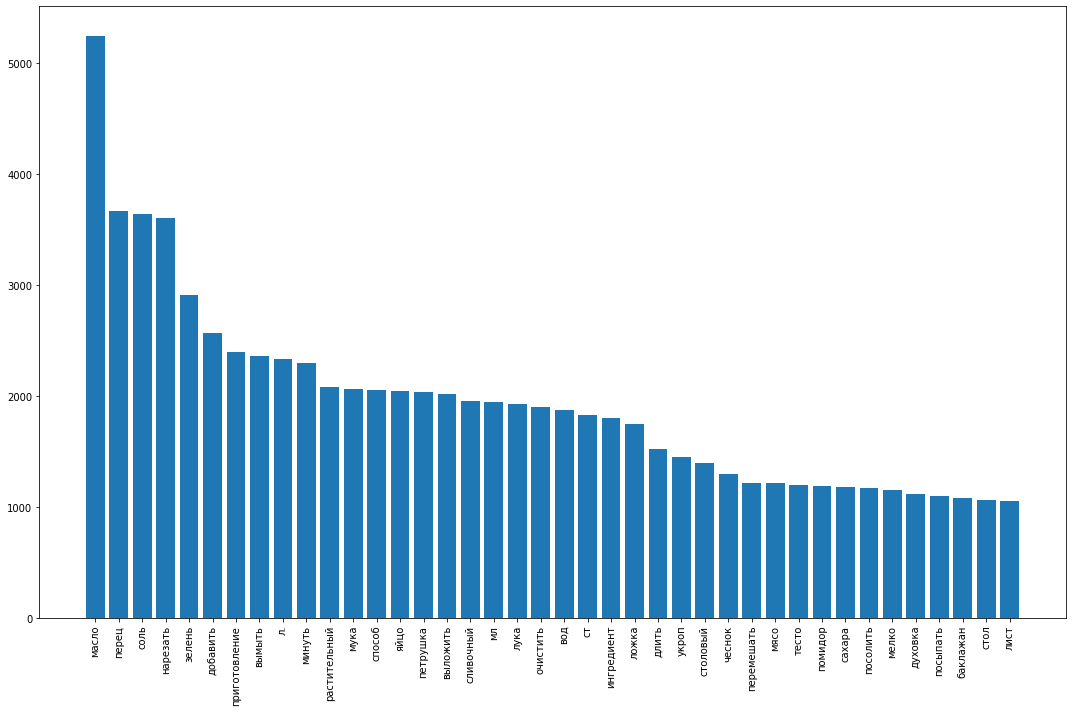

In [13]:
freq = freq_dist.most_common(40)

indices = np.arange(len(freq))
plt.figure(figsize=(15,10))
plt.bar(indices, list(map(lambda x: x[1], freq)))
plt.xticks(indices, list(map(lambda x: x[0], freq)), rotation='vertical')
plt.tight_layout()
plt.show()

## HAL Matrix

#### Считываем весь документ

In [14]:
print("Построение HAL матриц")
with open('doc.txt', 'r') as file:
         content = file.read().replace('\n', ' ')

Построение HAL матриц


#### Токенизируем и преобразуем в сет

In [15]:
print("Токенизируем весь текст")
tokens = list(set(tokenize_ru(content)))

Токенизируем весь текст


#### Берём окно, продвигаем его по всему тексту и для всех встреченных пар слов высчитываем расстояние

In [16]:
def hal_matrix(tokenized_text, all_tokens, frame_len=5):
    m_size =  len(all_tokens)
    hal = np.zeros([m_size, m_size])
    for t in range(len(tokenized_text)-frame_len):
        t_token = tokenized_text[t]
        for f_off in range(1, frame_len):
            off_token = tokenized_text[t+f_off]
            r = all_tokens.index(t_token)
            c = all_tokens.index(off_token)
            hal[r, c] += frame_len - f_off
#             hal[c, r] += frame_len - f_off
                
    return hal

#### Строим 8 HAL матриц для каждой темы документа

In [17]:
texts_count = 8
hal_matrices = dict()
for i in range(texts_count):
    print(f'Построение HAL матрицы для главы {i+1}')
    with open(f'{i}.txt', 'r') as file:
        content = file.read().replace('\n', ' ')
    tokenized_text = tokenize_ru(content)
    hal_matrices[i] = hal_matrix(tokenized_text, tokens, 5)

Построение HAL матрицы для главы 1
Построение HAL матрицы для главы 2
Построение HAL матрицы для главы 3
Построение HAL матрицы для главы 4
Построение HAL матрицы для главы 5
Построение HAL матрицы для главы 6
Построение HAL матрицы для главы 7
Построение HAL матрицы для главы 8


#### Выбираем топ 10 для каждого текста

In [18]:
hal_matrices_copy = hal_matrices
results = dict()
for m_n in range(texts_count):
    res = []
    for i in range(10):
        r, c = np.unravel_index(hal_matrices_copy[m_n].argmax(), hal_matrices_copy[m_n].shape)
        res.append(tokens[r] + ' '+ tokens[c])
        hal_matrices_copy[m_n][(r,c)] = -1
    results[m_n] = res
    
    

In [19]:
print("Топ 10 словосочетаний для каждой главы")
print(results)

Топ 10 словосочетаний для каждой главы
{0: ['ст л.', 'сливочный масло', 'ч. л.', 'сахарный пудра', 'растительный масло', 'л. соль', 'длить тест', 'духовка минуть', 'л. сахара', 'выпекать духовка'], 1: ['способ приготовление', 'столовый ложка', 'соль способ', 'растительный масло', 'сливочный масло', 'соль приготовление', 'мл растительный', 'вкус способ', 'мл масло', 'соль вкус'], 2: ['ст л.', 'сливочный масло', 'растительный масло', 'зелень петрушка', 'вымыть нарезать', 'разогреть °c', '°c духовка', 'разогреть духовка', 'перец соль', 'духовка минуть'], 3: ['способ приготовление', 'столовый ложка', 'соль способ', 'решётка пароварка', 'сливочный масло', 'соль приготовление', 'средний решётка', 'поставить средний', 'поставить решётка', 'средний пароварка'], 4: ['способ приготовление', 'соль способ', 'ст л.', 'перец способ', 'молотый перец', 'чёрный перец', 'соль приготовление', 'репчатый лука', 'ингредиент килограмм', 'соль перец'], 5: ['растительный масло', 'способ приготовление', 'соль с